In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt 
from PIL import Image

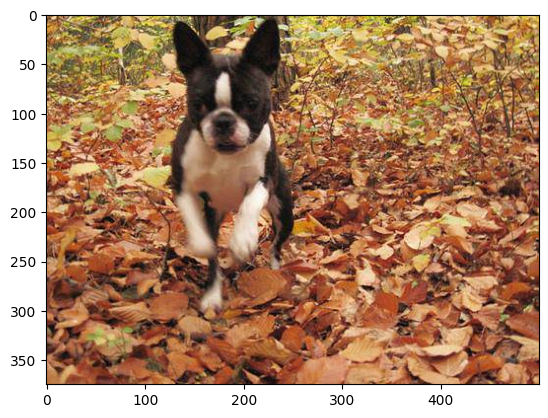

In [3]:
plt.imshow(plt.imread("/kaggle/input/competitions/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg"))

In [4]:
import pandas as pd 
label = pd.read_csv("/kaggle/input/competitions/dog-breed-identification/labels.csv")
unique_breeds = sorted(label.breed.unique())
breed_to_idx = {i:breed for i, breed in enumerate(unique_breeds)}
b_to_idx = {val : key for  key, val in breed_to_idx.items()}
label['target'] = label.breed.map(b_to_idx)
from sklearn.model_selection import train_test_split
y = label.pop('target')
X_train, X_test, y_train, y_test = train_test_split(label, y, test_size=0.2, random_state=42, stratify=y)
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class DogBreedDataset(Dataset):
    def __init__(self, df, y, root_dir, transform=None):
        self.df = df 
        self.y = y
        self.root_dir = root_dir
        self.transform = transform
        self.transforms = transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # 사진이 있는 경로 
        img_id = self.df.iloc[idx,0]
        img_name = os.path.join(self.root_dir,img_id ) + ".jpg"

        image = Image.open(img_name).convert('RGB')
        label = self.y.iloc[idx]

        if self.transform == True:
            image = self.transforms(image)

        return image, label     

In [29]:
train_dataset = DogBreedDataset(X_train, y_train, "/kaggle/input/competitions/dog-breed-identification/train", transform=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = DogBreedDataset(X_test, y_test, "/kaggle/input/competitions/dog-breed-identification/train", transform=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [20]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights
import torch
import torch.nn as nn
from torchvision import models

In [25]:
from torchvision.models import VGG16_Weights
from torchvision import models
import torch.nn as nn

In [30]:
class VGG16TransferLearning(nn.Module):
    def __init__(self, num_classes: int, mode: str = 'feature_extraction'):
        super(VGG16TransferLearning, self).__init__()


        self.backbone = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)


        # 2. Feature Extractor (conv layers) 동결 설정
        if mode == 'feature_extraction':
            # 모든 conv layer 파라미터 동결 (gradient 계산 중단)
            for param in self.backbone.features.parameters():
                param.requires_grad = False  
               
        elif mode == 'fine_tuning':
            # 마지막 Conv Block (block 4, 5)만 학습 가능하도록 설정
            # VGG16의 features는 [0-30] 인덱스까지 (31개 layer)
            freeze_until = 24  # block 3까지 동결 (인덱스 0-23)
            for idx, param in enumerate(self.backbone.features.parameters()):
                if idx < freeze_until:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
                    print(f"Fine-tuning enabled at layer index: {idx}")


        in_features = self.backbone.classifier[6].in_features
        self.backbone.classifier[6] = nn.Linear(in_features, num_classes)
     


        self._initialize_weights()


    def _initialize_weights(self):
        """새로 추가된 FC 레이어 가중치 초기화"""
        for m in self.backbone.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


    def forward(self, x):
        return self.backbone(x)


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
device

device(type='cuda', index=0)

In [31]:
NUM_CLASSES = 120  # 예: CIFAR-10 또는 커스텀 데이터셋
BATCH_SIZE = 32   # VGG16은 메모리를 많이 사용하므로 16-32 권장
NUM_EPOCHS = 30
MODE = 'feature_extraction'  # 또는 'feature_extraction'

In [32]:
model = VGG16TransferLearning(num_classes=NUM_CLASSES, mode=MODE)
model = model.to(device)

In [23]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
VGG16TransferLearning                    --
├─VGG: 1-1                               --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  (1,792)
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  (36,928)
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  (73,856)
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  (147,584)
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 (295,168)
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 (590,080)
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 (590,080)
│    │    └─ReLU: 3-16                   --
│    │    └─MaxPool2d: 3-17              --
│    │    └─Conv2d: 3-18  

In [33]:
import torch.optim as optim
if MODE == 'feature_extraction':
    # FC layer만 학습하므로 일반적인 LR 사용 가능
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,
        weight_decay=1e-4  # L2 정규화 (과적합 방지)
    )
else:  # fine_tuning
    # 전체 네트워크 미세 조정 시 매우 작은 LR 필요
    # VGG16은 깊은 네트워크이므로 SGD + Momentum이 더 안정적
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,          # ImageNet 학습률의 1/10 이하
        momentum=0.9,     # 관성항으로 안정적 수렴
        weight_decay=5e-4
    )
def train_model(model, dataloaders, criterion, optimizer,
                num_epochs=25, device='cuda'):
    """
    전이학습 학습 루프


    Args:
        model: VGG16TransferLearning 인스턴스
        dataloaders: {'train': DataLoader, 'val': DataLoader}
        criterion: 손실 함수 (CrossEntropyLoss)
        optimizer: optimizer (SGD with momentum 권장)
    """
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}


    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)


        # 각 epoch마다 train -> val phase 순환
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Dropout 활성화, BN 학습 모드
            else:
                model.eval()   # Dropout 비활성화, BN 추론 모드


            running_loss = 0.0
            running_corrects = 0


            # 진행률 표시
            pbar = tqdm(dataloaders[phase], desc=phase)


            for inputs, labels in pbar:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)


                # gradient 누적 초기화
                optimizer.zero_grad()


                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # 예측 클래스
                    loss = criterion(outputs, labels)


                    # Backward + Optimize (train phase only)
                    if phase == 'train':
                        loss.backward()


                        # Gradient Clipping (VGG16은 깊어서 안정성을 위해 권장)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


                        optimizer.step()


                # 통계 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


                # tqdm 업데이트
                pbar.set_postfix({'loss': loss.item()})


            # Epoch 통계
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            # 최적 모델 저장 (validation 기준)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
                torch.save(best_model_wts, 'best_vgg16_transfer.pth')


        # 학습률 업데이트
        # if scheduler is not None:
        #     if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
        #         scheduler.step(epoch_loss)  # val loss 기준
        #     else:
        #         scheduler.step()


    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history


In [35]:
dataloaders = {'train' : train_loader , 'val' : test_loader}
model, history = train_model(
        model, dataloaders, criterion, optimizer,
        num_epochs=NUM_EPOCHS, device=device
    )


Epoch 1/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:03<00:00,  4.02it/s, loss=0.852]   


train Loss: 0.7730 Acc: 0.9144


val: 100%|██████████| 64/64 [00:14<00:00,  4.48it/s, loss=3.29]


val Loss: 3.7104 Acc: 0.6469

Epoch 2/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:02<00:00,  4.13it/s, loss=0.379]  


train Loss: 0.7637 Acc: 0.9181


val: 100%|██████████| 64/64 [00:13<00:00,  4.60it/s, loss=5.95] 


val Loss: 3.8357 Acc: 0.6601

Epoch 3/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, loss=0.0814] 


train Loss: 0.7092 Acc: 0.9204


val: 100%|██████████| 64/64 [00:13<00:00,  4.72it/s, loss=4.64] 


val Loss: 3.7094 Acc: 0.6430

Epoch 4/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:02<00:00,  4.10it/s, loss=0.268]   


train Loss: 0.6986 Acc: 0.9209


val: 100%|██████████| 64/64 [00:14<00:00,  4.55it/s, loss=4.47]


val Loss: 3.6910 Acc: 0.6641

Epoch 5/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:02<00:00,  4.07it/s, loss=1.07]    


train Loss: 0.6731 Acc: 0.9223


val: 100%|██████████| 64/64 [00:14<00:00,  4.50it/s, loss=3.72]


val Loss: 3.8063 Acc: 0.6513

Epoch 6/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.16it/s, loss=0.352]   


train Loss: 0.5873 Acc: 0.9280


val: 100%|██████████| 64/64 [00:14<00:00,  4.55it/s, loss=2.94] 


val Loss: 3.5403 Acc: 0.6694

Epoch 7/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:02<00:00,  4.09it/s, loss=0.691]   


train Loss: 0.5700 Acc: 0.9294


val: 100%|██████████| 64/64 [00:13<00:00,  4.63it/s, loss=3.41]


val Loss: 3.5332 Acc: 0.6665

Epoch 8/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:02<00:00,  4.11it/s, loss=0.321]   


train Loss: 0.6317 Acc: 0.9236


val: 100%|██████████| 64/64 [00:13<00:00,  4.65it/s, loss=3.58]


val Loss: 3.5432 Acc: 0.6504

Epoch 9/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, loss=1.12]    


train Loss: 0.6032 Acc: 0.9296


val: 100%|██████████| 64/64 [00:13<00:00,  4.64it/s, loss=4.06] 


val Loss: 3.6983 Acc: 0.6543

Epoch 10/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, loss=0.423]   


train Loss: 0.5088 Acc: 0.9365


val: 100%|██████████| 64/64 [00:13<00:00,  4.73it/s, loss=3.19] 


val Loss: 3.4960 Acc: 0.6660

Epoch 11/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.20it/s, loss=0.687]   


train Loss: 0.5257 Acc: 0.9329


val: 100%|██████████| 64/64 [00:13<00:00,  4.72it/s, loss=4.22] 


val Loss: 3.4047 Acc: 0.6743

Epoch 12/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:00<00:00,  4.23it/s, loss=7.76e-6] 


train Loss: 0.4650 Acc: 0.9414


val: 100%|██████████| 64/64 [00:13<00:00,  4.72it/s, loss=3.83]


val Loss: 3.4562 Acc: 0.6694

Epoch 13/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:00<00:00,  4.20it/s, loss=0.00923] 


train Loss: 0.5074 Acc: 0.9335


val: 100%|██████████| 64/64 [00:13<00:00,  4.61it/s, loss=3.3] 


val Loss: 3.4988 Acc: 0.6655

Epoch 14/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, loss=2.34e-5] 


train Loss: 0.5299 Acc: 0.9375


val: 100%|██████████| 64/64 [00:13<00:00,  4.61it/s, loss=2.53] 


val Loss: 3.5194 Acc: 0.6768

Epoch 15/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:02<00:00,  4.11it/s, loss=1.14e-5] 


train Loss: 0.4843 Acc: 0.9365


val: 100%|██████████| 64/64 [00:13<00:00,  4.62it/s, loss=4.8] 


val Loss: 3.6642 Acc: 0.6714

Epoch 16/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:02<00:00,  4.09it/s, loss=0.606]   


train Loss: 0.4517 Acc: 0.9426


val: 100%|██████████| 64/64 [00:13<00:00,  4.65it/s, loss=3.41]


val Loss: 3.5388 Acc: 0.6611

Epoch 17/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.15it/s, loss=0.6]     


train Loss: 0.4380 Acc: 0.9440


val: 100%|██████████| 64/64 [00:13<00:00,  4.63it/s, loss=7.91]


val Loss: 3.5656 Acc: 0.6694

Epoch 18/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, loss=0.34]    


train Loss: 0.3803 Acc: 0.9489


val: 100%|██████████| 64/64 [00:13<00:00,  4.67it/s, loss=2.31]


val Loss: 3.3633 Acc: 0.6689

Epoch 19/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.16it/s, loss=1.55]    


train Loss: 0.4160 Acc: 0.9437


val: 100%|██████████| 64/64 [00:13<00:00,  4.69it/s, loss=3.89]


val Loss: 3.5415 Acc: 0.6660

Epoch 20/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, loss=1.18]    


train Loss: 0.4327 Acc: 0.9474


val: 100%|██████████| 64/64 [00:14<00:00,  4.48it/s, loss=6.68]


val Loss: 3.3570 Acc: 0.6650

Epoch 21/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, loss=0.00674] 


train Loss: 0.3983 Acc: 0.9466


val: 100%|██████████| 64/64 [00:13<00:00,  4.73it/s, loss=5.36]


val Loss: 3.3618 Acc: 0.6694

Epoch 22/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, loss=0.112]   


train Loss: 0.3836 Acc: 0.9472


val: 100%|██████████| 64/64 [00:13<00:00,  4.72it/s, loss=4.52]


val Loss: 3.3997 Acc: 0.6866

Epoch 23/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:00<00:00,  4.23it/s, loss=0.486]   


train Loss: 0.4115 Acc: 0.9488


val: 100%|██████████| 64/64 [00:13<00:00,  4.73it/s, loss=3.91] 


val Loss: 3.2092 Acc: 0.6880

Epoch 24/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:00<00:00,  4.20it/s, loss=0.00432] 


train Loss: 0.3295 Acc: 0.9499


val: 100%|██████████| 64/64 [00:13<00:00,  4.69it/s, loss=3.25]


val Loss: 3.5231 Acc: 0.6645

Epoch 25/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:00<00:00,  4.20it/s, loss=0.0892]  


train Loss: 0.3423 Acc: 0.9517


val: 100%|██████████| 64/64 [00:13<00:00,  4.67it/s, loss=4.64]


val Loss: 3.3397 Acc: 0.6802

Epoch 26/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, loss=0.00016] 


train Loss: 0.3282 Acc: 0.9524


val: 100%|██████████| 64/64 [00:13<00:00,  4.68it/s, loss=3.16] 


val Loss: 3.1779 Acc: 0.6822

Epoch 27/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.20it/s, loss=1.18]    


train Loss: 0.3183 Acc: 0.9556


val: 100%|██████████| 64/64 [00:13<00:00,  4.65it/s, loss=2.88] 


val Loss: 3.0768 Acc: 0.6846

Epoch 28/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, loss=0.00614] 


train Loss: 0.3328 Acc: 0.9549


val: 100%|██████████| 64/64 [00:13<00:00,  4.73it/s, loss=2.72] 


val Loss: 3.3308 Acc: 0.6704

Epoch 29/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, loss=0.28]    


train Loss: 0.3769 Acc: 0.9501


val: 100%|██████████| 64/64 [00:14<00:00,  4.55it/s, loss=4.37]


val Loss: 3.1534 Acc: 0.6743

Epoch 30/30
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, loss=3.01e-5] 


train Loss: 0.3167 Acc: 0.9527


val: 100%|██████████| 64/64 [00:13<00:00,  4.71it/s, loss=2.12] 

val Loss: 3.2534 Acc: 0.6792

Best val Acc: 0.6880


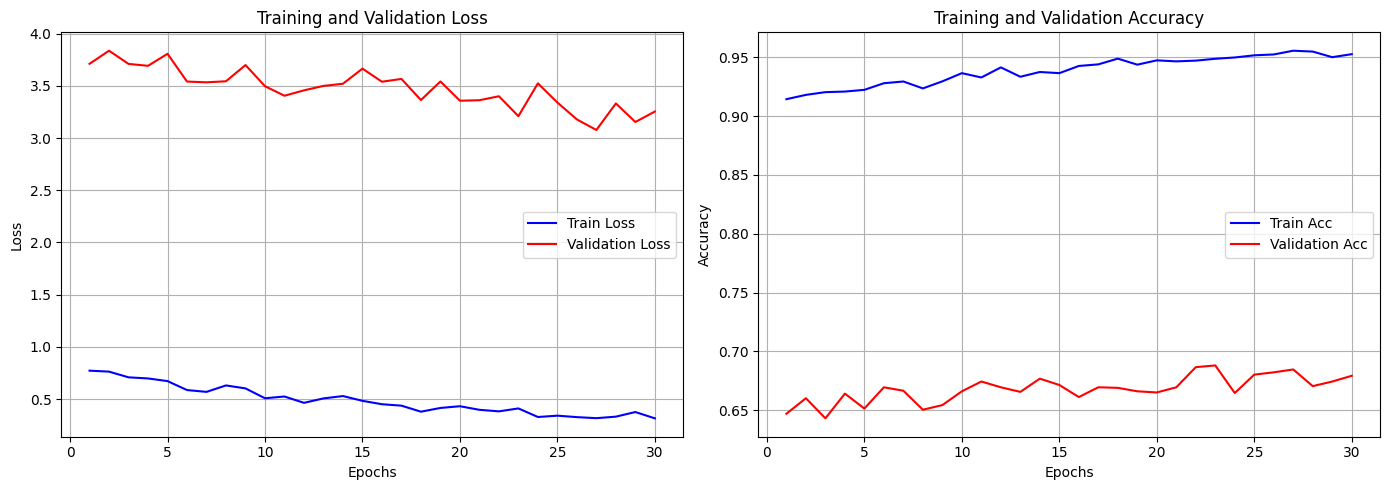

In [36]:
epochs = range(1, len(history['train_loss']) + 1)


# 그래프 그리기 시작
plt.figure(figsize=(14, 5))


# 1. Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# 2. Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
plt.plot(epochs, history['val_acc'], 'r-', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class DogBreedDataset(Dataset):
    def __init__(self, df, y, root_dir, transform=None):
        self.df = df 
        self.y = y
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        # 사진이 있는 경로 
        img_id = self.df.iloc[idx,0]
        img_name = os.path.join(self.root_dir,img_id ) + ".jpg"


        image = Image.open(img_name).convert('RGB')
        label = self.y.iloc[idx]


        if self.transform:
            image = self.transform(image)


        return image, label   


In [38]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [39]:
train_dataset = DogBreedDataset(X_train, y_train, "/kaggle/input/competitions/dog-breed-identification/train", transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = DogBreedDataset(X_test, y_test, "/kaggle/input/competitions/dog-breed-identification/train", transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [40]:
model = VGG16TransferLearning(num_classes=NUM_CLASSES, mode=MODE)
model = model.to(device)

In [42]:
criterion = nn.CrossEntropyLoss() 
import torch.optim as optim
if MODE == 'feature_extraction':
    # FC layer만 학습하므로 일반적인 LR 사용 가능
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,
        weight_decay=1e-4  # L2 정규화 (과적합 방지)
    )
else:  # fine_tuning
    # 전체 네트워크 미세 조정 시 매우 작은 LR 필요
    # VGG16은 깊은 네트워크이므로 SGD + Momentum이 더 안정적
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,          # ImageNet 학습률의 1/10 이하
        momentum=0.9,     # 관성항으로 안정적 수렴
        weight_decay=5e-4
    )

In [ ]:
dataloaders = {'train' : train_loader , 'val' : test_loader}
model, history = train_model(
        model, dataloaders, criterion, optimizer, 
        num_epochs=NUM_EPOCHS, device=device
    )


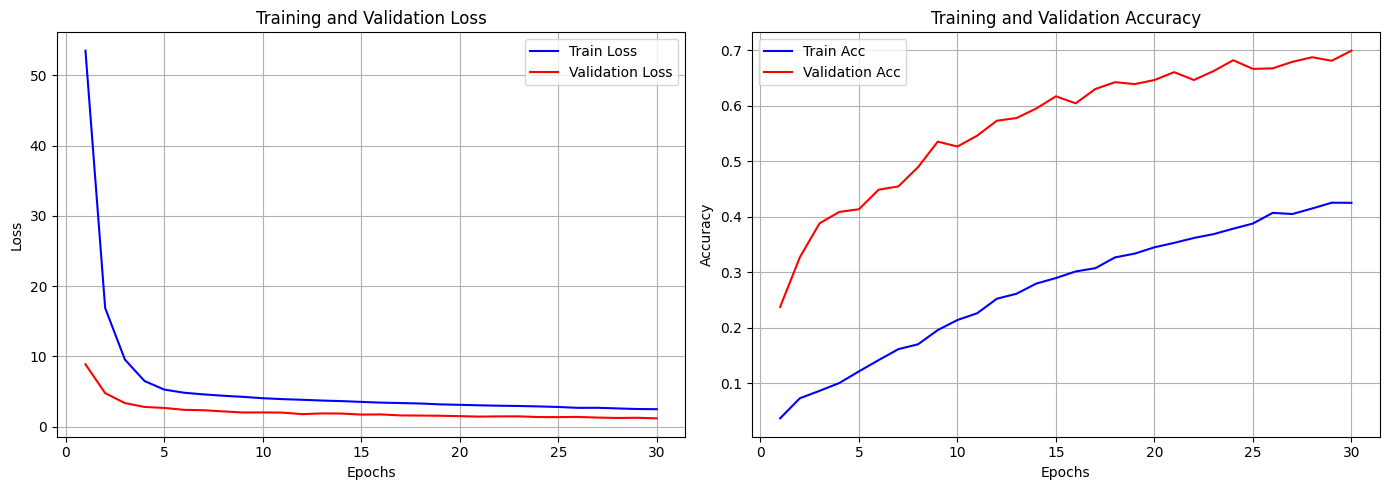

In [44]:
epochs = range(1, len(history['train_loss']) + 1)


# 그래프 그리기 시작
plt.figure(figsize=(14, 5))


# 1. Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# 2. Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
plt.plot(epochs, history['val_acc'], 'r-', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


In [46]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = DogBreedDataset(X_train, y_train, "/kaggle/input/competitions/dog-breed-identification/train", transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = DogBreedDataset(X_test, y_test, "/kaggle/input/competitions/dog-breed-identification/train", transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)



MODE = 'fine_tuning'  # 또는 'feature_extraction'
model = VGG16TransferLearning(num_classes=NUM_CLASSES, mode=MODE)
model = model.to(device)

criterion = nn.CrossEntropyLoss() 
import torch.optim as optim
if MODE == 'feature_extraction':
    # FC layer만 학습하므로 일반적인 LR 사용 가능
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,
        weight_decay=1e-4  # L2 정규화 (과적합 방지)
    )
else:  # fine_tuning
    # 전체 네트워크 미세 조정 시 매우 작은 LR 필요
    # VGG16은 깊은 네트워크이므로 SGD + Momentum이 더 안정적
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,          # ImageNet 학습률의 1/10 이하
        momentum=0.9,     # 관성항으로 안정적 수렴
        weight_decay=5e-4
    )

NUM_EPOCHS = 35
dataloaders = {'train' : train_loader , 'val' : test_loader}
model, history = train_model(
        model, dataloaders, criterion, optimizer, 
        num_epochs=NUM_EPOCHS, device=device
    )

Fine-tuning enabled at layer index: 24
Fine-tuning enabled at layer index: 25

Epoch 1/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:19<00:00,  3.23it/s, loss=128]


train Loss: 139.4950 Acc: 0.0089


val: 100%|██████████| 64/64 [00:16<00:00,  3.93it/s, loss=74.1]


val Loss: 85.2220 Acc: 0.0088

Epoch 2/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:19<00:00,  3.24it/s, loss=133]


train Loss: 136.4218 Acc: 0.0072


val: 100%|██████████| 64/64 [00:16<00:00,  3.95it/s, loss=57.1]


val Loss: 79.8732 Acc: 0.0093

Epoch 3/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:20<00:00,  3.18it/s, loss=128]


train Loss: 131.6241 Acc: 0.0086


val: 100%|██████████| 64/64 [00:16<00:00,  3.89it/s, loss=72]  


val Loss: 75.8409 Acc: 0.0112

Epoch 4/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:19<00:00,  3.21it/s, loss=155]


train Loss: 126.7265 Acc: 0.0095


val: 100%|██████████| 64/64 [00:15<00:00,  4.08it/s, loss=67.3]


val Loss: 72.5500 Acc: 0.0117

Epoch 5/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.35it/s, loss=120] 


train Loss: 125.3389 Acc: 0.0072


val: 100%|██████████| 64/64 [00:15<00:00,  4.12it/s, loss=63.3]


val Loss: 69.7849 Acc: 0.0127

Epoch 6/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.38it/s, loss=109] 


train Loss: 122.5982 Acc: 0.0088


val: 100%|██████████| 64/64 [00:15<00:00,  4.07it/s, loss=73.9]


val Loss: 67.3708 Acc: 0.0127

Epoch 7/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.41it/s, loss=104] 


train Loss: 119.8472 Acc: 0.0092


val: 100%|██████████| 64/64 [00:15<00:00,  4.03it/s, loss=64.7]


val Loss: 65.2456 Acc: 0.0122

Epoch 8/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s, loss=119] 


train Loss: 118.1270 Acc: 0.0068


val: 100%|██████████| 64/64 [00:16<00:00,  4.00it/s, loss=58]  


val Loss: 63.2993 Acc: 0.0117

Epoch 9/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.35it/s, loss=139] 


train Loss: 114.7036 Acc: 0.0083


val: 100%|██████████| 64/64 [00:15<00:00,  4.04it/s, loss=55.4]


val Loss: 61.5472 Acc: 0.0112

Epoch 10/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.39it/s, loss=116] 


train Loss: 113.2546 Acc: 0.0089


val: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s, loss=57.5]


val Loss: 59.9366 Acc: 0.0117

Epoch 11/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.40it/s, loss=109] 


train Loss: 111.2649 Acc: 0.0103


val: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s, loss=60.5]


val Loss: 58.4171 Acc: 0.0112

Epoch 12/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.35it/s, loss=92.8]


train Loss: 107.0214 Acc: 0.0073


val: 100%|██████████| 64/64 [00:15<00:00,  4.13it/s, loss=53.9]


val Loss: 57.0262 Acc: 0.0122

Epoch 13/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.42it/s, loss=120] 


train Loss: 106.6518 Acc: 0.0088


val: 100%|██████████| 64/64 [00:15<00:00,  4.08it/s, loss=57.2]


val Loss: 55.7218 Acc: 0.0112

Epoch 14/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.42it/s, loss=98.7]


train Loss: 104.2449 Acc: 0.0094


val: 100%|██████████| 64/64 [00:15<00:00,  4.03it/s, loss=49.4]


val Loss: 54.4509 Acc: 0.0112

Epoch 15/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.37it/s, loss=110] 


train Loss: 103.1171 Acc: 0.0102


val: 100%|██████████| 64/64 [00:15<00:00,  4.09it/s, loss=52.5]


val Loss: 53.2613 Acc: 0.0117

Epoch 16/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.41it/s, loss=93.1]


train Loss: 101.7662 Acc: 0.0093


val: 100%|██████████| 64/64 [00:15<00:00,  4.07it/s, loss=50.2]


val Loss: 52.1260 Acc: 0.0127

Epoch 17/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.45it/s, loss=107] 


train Loss: 100.3930 Acc: 0.0098


val: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s, loss=51.8]


val Loss: 51.0485 Acc: 0.0127

Epoch 18/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:13<00:00,  3.49it/s, loss=123] 


train Loss: 97.3081 Acc: 0.0092


val: 100%|██████████| 64/64 [00:15<00:00,  4.16it/s, loss=50.7]


val Loss: 50.0316 Acc: 0.0137

Epoch 19/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.46it/s, loss=96.8]


train Loss: 97.6464 Acc: 0.0084


val: 100%|██████████| 64/64 [00:15<00:00,  4.20it/s, loss=47.9]


val Loss: 49.0673 Acc: 0.0142

Epoch 20/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:13<00:00,  3.49it/s, loss=104] 


train Loss: 96.3178 Acc: 0.0075


val: 100%|██████████| 64/64 [00:15<00:00,  4.23it/s, loss=54.1]


val Loss: 48.0762 Acc: 0.0147

Epoch 21/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:13<00:00,  3.47it/s, loss=106] 


train Loss: 93.1643 Acc: 0.0079


val: 100%|██████████| 64/64 [00:15<00:00,  4.13it/s, loss=45.2]


val Loss: 47.1764 Acc: 0.0142

Epoch 22/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s, loss=84.8]


train Loss: 92.9450 Acc: 0.0089


val: 100%|██████████| 64/64 [00:16<00:00,  3.88it/s, loss=44.8]


val Loss: 46.2912 Acc: 0.0147

Epoch 23/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:13<00:00,  3.50it/s, loss=111] 


train Loss: 91.2028 Acc: 0.0106


val: 100%|██████████| 64/64 [00:15<00:00,  4.25it/s, loss=47.5]


val Loss: 45.4376 Acc: 0.0147

Epoch 24/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.34it/s, loss=79.5]


train Loss: 88.5505 Acc: 0.0090


val: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s, loss=46.5]


val Loss: 44.6068 Acc: 0.0147

Epoch 25/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.41it/s, loss=108] 


train Loss: 87.5410 Acc: 0.0068


val: 100%|██████████| 64/64 [00:15<00:00,  4.13it/s, loss=38.9]


val Loss: 43.8205 Acc: 0.0142

Epoch 26/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.41it/s, loss=79.9]


train Loss: 86.8574 Acc: 0.0102


val: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s, loss=39.7]


val Loss: 43.0501 Acc: 0.0142

Epoch 27/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.42it/s, loss=76.9]


train Loss: 85.6370 Acc: 0.0090


val: 100%|██████████| 64/64 [00:15<00:00,  4.16it/s, loss=40.1]


val Loss: 42.3126 Acc: 0.0147

Epoch 28/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.39it/s, loss=74.1]


train Loss: 84.5008 Acc: 0.0098


val: 100%|██████████| 64/64 [00:15<00:00,  4.09it/s, loss=40.1]


val Loss: 41.5816 Acc: 0.0147

Epoch 29/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.43it/s, loss=79.3]


train Loss: 82.9302 Acc: 0.0108


val: 100%|██████████| 64/64 [00:15<00:00,  4.20it/s, loss=40.2]


val Loss: 40.8690 Acc: 0.0147

Epoch 30/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.40it/s, loss=66.9]


train Loss: 80.5297 Acc: 0.0098


val: 100%|██████████| 64/64 [00:15<00:00,  4.25it/s, loss=35.7]


val Loss: 40.2011 Acc: 0.0147

Epoch 31/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.46it/s, loss=97.8]


train Loss: 80.9068 Acc: 0.0097


val: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s, loss=29.6]


val Loss: 39.5465 Acc: 0.0156

Epoch 32/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.44it/s, loss=74.2]


train Loss: 80.8021 Acc: 0.0090


val: 100%|██████████| 64/64 [00:15<00:00,  4.25it/s, loss=43.7]


val Loss: 38.8945 Acc: 0.0161

Epoch 33/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.45it/s, loss=63.3]


train Loss: 79.1829 Acc: 0.0115


val: 100%|██████████| 64/64 [00:15<00:00,  4.22it/s, loss=38.5]


val Loss: 38.2603 Acc: 0.0161

Epoch 34/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:13<00:00,  3.48it/s, loss=89.6]


train Loss: 76.6998 Acc: 0.0102


val: 100%|██████████| 64/64 [00:15<00:00,  4.20it/s, loss=41.4]


val Loss: 37.6408 Acc: 0.0166

Epoch 35/35
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.43it/s, loss=76.3]


train Loss: 76.3387 Acc: 0.0089


val: 100%|██████████| 64/64 [00:15<00:00,  4.20it/s, loss=34.1]

val Loss: 37.0445 Acc: 0.0161

Best val Acc: 0.0166


In [48]:
class DogBreedDataset(Dataset):
    def __init__(self, df, y, root_dir, transform=None):
        self.df = df
        self.y = y
        self.root_dir = root_dir
        self.transform = transform




    def __len__(self):
        return len(self.df)




    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()




        # 사진이 있는 경로
        img_id = self.df.iloc[idx,0]
        img_name = os.path.join(self.root_dir,img_id ) + ".jpg"




        image = Image.open(img_name).convert('RGB')
        label = self.y.iloc[idx]




        if self.transform:
            image = self.transform(image)




        return image, label    
       




train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])




val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])




train_dataset = DogBreedDataset(X_train, y_train, "/kaggle/input/competitions/dog-breed-identification/train", transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = DogBreedDataset(X_test, y_test, "/kaggle/input/competitions/dog-breed-identification/train", transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
NUM_CLASSES = 120  # 예: CIFAR-10 또는 커스텀 데이터셋
BATCH_SIZE = 32   # VGG16은 메모리를 많이 사용하므로 16-32 권장
NUM_EPOCHS = 60
MODE = 'fine_tuing'  # 또는 'feature_extraction'


from torchvision.models import VGG16_Weights
from torchvision import models
import torch.nn as nn
class VGG16TransferLearning(nn.Module):
    def __init__(self, num_classes: int, mode: str = 'feature_extraction'):
        super(VGG16TransferLearning, self).__init__()




        self.backbone = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)




        # 2. Feature Extractor (conv layers) 동결 설정
        if mode == 'feature_extraction':
            # 모든 conv layer 파라미터 동결 (gradient 계산 중단)
            for param in self.backbone.features.parameters():
                param.requires_grad = False  
               
        elif mode == 'fine_tuning':
            # 마지막 Conv Block (block 4, 5)만 학습 가능하도록 설정
            # VGG16의 features는 [0-30] 인덱스까지 (31개 layer)
            freeze_until = 21  # block 3까지 동결 (인덱스 0-23)
            for idx, param in enumerate(self.backbone.features.parameters()):
                if idx < freeze_until:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
                    print(f"Fine-tuning enabled at layer index: {idx}")




        in_features = self.backbone.classifier[6].in_features
        self.backbone.classifier[6] = nn.Linear(in_features, num_classes)
     




        #self._initialize_weights()




    def _initialize_weights(self):
        """새로 추가된 FC 레이어 가중치 초기화"""
        for m in self.backbone.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)




    def forward(self, x):
        return self.backbone(x)


def train_model(model, dataloaders, criterion, optimizer,
                num_epochs=25, device='cuda'):
    """
    전이학습 학습 루프




    Args:
        model: VGG16TransferLearning 인스턴스
        dataloaders: {'train': DataLoader, 'val': DataLoader}
        criterion: 손실 함수 (CrossEntropyLoss)
        optimizer: optimizer (SGD with momentum 권장)
    """
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}




    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)




        # 각 epoch마다 train -> val phase 순환
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Dropout 활성화, BN 학습 모드
            else:
                model.eval()   # Dropout 비활성화, BN 추론 모드




            running_loss = 0.0
            running_corrects = 0




            # 진행률 표시
            pbar = tqdm(dataloaders[phase], desc=phase)




            for inputs, labels in pbar:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)




                # gradient 누적 초기화
                optimizer.zero_grad()




                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # 예측 클래스
                    loss = criterion(outputs, labels)




                    # Backward + Optimize (train phase only)
                    if phase == 'train':
                        loss.backward()




                        # Gradient Clipping (VGG16은 깊어서 안정성을 위해 권장)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)




                        optimizer.step()




                # 통계 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)




                # tqdm 업데이트
                pbar.set_postfix({'loss': loss.item()})




            # Epoch 통계
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)




            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())




            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')




            # 최적 모델 저장 (validation 기준)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
                torch.save(best_model_wts, 'best_vgg16_transfer.pth')




        # 학습률 업데이트
        # if scheduler is not None:
        #     if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
        #         scheduler.step(epoch_loss)  # val loss 기준
        #     else:
        #         scheduler.step()




    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history




model = VGG16TransferLearning(num_classes=NUM_CLASSES, mode='fine_tuning')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
import torch.optim as optim
if MODE == 'feature_extraction':
    # FC layer만 학습하므로 일반적인 LR 사용 가능
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,
        weight_decay=1e-4  # L2 정규화 (과적합 방지)
    )
else:  # fine_tuning
    # 전체 네트워크 미세 조정 시 매우 작은 LR 필요
    # VGG16은 깊은 네트워크이므로 SGD + Momentum이 더 안정적
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-2,          # ImageNet 학습률의 1/10 이하
        momentum=0.9,     # 관성항으로 안정적 수렴
        weight_decay=5e-4
    )




dataloaders = {'train' : train_loader , 'val' : test_loader}
model, history = train_model(
        model, dataloaders, criterion, optimizer,
        num_epochs=NUM_EPOCHS, device=device
    )


Fine-tuning enabled at layer index: 21
Fine-tuning enabled at layer index: 22
Fine-tuning enabled at layer index: 23
Fine-tuning enabled at layer index: 24
Fine-tuning enabled at layer index: 25

Epoch 1/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:23<00:00,  3.08it/s, loss=1.95] 


train Loss: 2.8887 Acc: 0.3298


val: 100%|██████████| 64/64 [00:15<00:00,  4.03it/s, loss=1.18] 


val Loss: 0.9106 Acc: 0.7350

Epoch 2/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s, loss=1.09]


train Loss: 1.7901 Acc: 0.5227


val: 100%|██████████| 64/64 [00:15<00:00,  4.11it/s, loss=0.716]


val Loss: 0.8008 Acc: 0.7526

Epoch 3/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:18<00:00,  3.28it/s, loss=1.58] 


train Loss: 1.5870 Acc: 0.5688


val: 100%|██████████| 64/64 [00:15<00:00,  4.00it/s, loss=0.642]


val Loss: 0.7262 Acc: 0.7716

Epoch 4/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:21<00:00,  3.15it/s, loss=1.19] 


train Loss: 1.4961 Acc: 0.5880


val: 100%|██████████| 64/64 [00:15<00:00,  4.06it/s, loss=0.983]


val Loss: 0.6941 Acc: 0.7892

Epoch 5/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s, loss=1.5]  


train Loss: 1.4216 Acc: 0.6124


val: 100%|██████████| 64/64 [00:15<00:00,  4.06it/s, loss=0.375]


val Loss: 0.7138 Acc: 0.7804

Epoch 6/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s, loss=1.3]  


train Loss: 1.3709 Acc: 0.6160


val: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s, loss=0.735]


val Loss: 0.6698 Acc: 0.7888

Epoch 7/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:17<00:00,  3.31it/s, loss=2.09] 


train Loss: 1.3290 Acc: 0.6290


val: 100%|██████████| 64/64 [00:15<00:00,  4.02it/s, loss=0.869]


val Loss: 0.6510 Acc: 0.7956

Epoch 8/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:18<00:00,  3.28it/s, loss=1.29] 


train Loss: 1.3137 Acc: 0.6296


val: 100%|██████████| 64/64 [00:15<00:00,  4.08it/s, loss=0.595]


val Loss: 0.6663 Acc: 0.7971

Epoch 9/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s, loss=0.4]  


train Loss: 1.3020 Acc: 0.6361


val: 100%|██████████| 64/64 [00:15<00:00,  4.09it/s, loss=0.411]


val Loss: 0.6920 Acc: 0.7907

Epoch 10/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:17<00:00,  3.31it/s, loss=0.926]


train Loss: 1.2692 Acc: 0.6441


val: 100%|██████████| 64/64 [00:15<00:00,  4.07it/s, loss=1.11] 


val Loss: 0.6699 Acc: 0.7834

Epoch 11/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:18<00:00,  3.27it/s, loss=1.8]  


train Loss: 1.2193 Acc: 0.6625


val: 100%|██████████| 64/64 [00:15<00:00,  4.07it/s, loss=0.57] 


val Loss: 0.6298 Acc: 0.8112

Epoch 12/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.34it/s, loss=1.24] 


train Loss: 1.2144 Acc: 0.6592


val: 100%|██████████| 64/64 [00:15<00:00,  4.07it/s, loss=0.898] 


val Loss: 0.6606 Acc: 0.8000

Epoch 13/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.35it/s, loss=0.922]


train Loss: 1.2270 Acc: 0.6612


val: 100%|██████████| 64/64 [00:16<00:00,  3.84it/s, loss=0.402]


val Loss: 0.6732 Acc: 0.7951

Epoch 14/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:20<00:00,  3.16it/s, loss=1.01] 


train Loss: 1.1762 Acc: 0.6704


val: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s, loss=0.578]


val Loss: 0.7059 Acc: 0.7844

Epoch 15/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s, loss=1.92] 


train Loss: 1.1817 Acc: 0.6714


val: 100%|██████████| 64/64 [00:15<00:00,  4.20it/s, loss=0.658]


val Loss: 0.6979 Acc: 0.7814

Epoch 16/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s, loss=0.664]


train Loss: 1.1584 Acc: 0.6709


val: 100%|██████████| 64/64 [00:15<00:00,  4.07it/s, loss=0.572]


val Loss: 0.6688 Acc: 0.7922

Epoch 17/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:17<00:00,  3.31it/s, loss=0.622]


train Loss: 1.1460 Acc: 0.6796


val: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s, loss=0.335]


val Loss: 0.6536 Acc: 0.7946

Epoch 18/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.34it/s, loss=1.47] 


train Loss: 1.1314 Acc: 0.6780


val: 100%|██████████| 64/64 [00:15<00:00,  4.11it/s, loss=0.78] 


val Loss: 0.6567 Acc: 0.8005

Epoch 19/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.34it/s, loss=0.809]


train Loss: 1.1408 Acc: 0.6823


val: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s, loss=0.469]


val Loss: 0.6408 Acc: 0.8117

Epoch 20/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s, loss=0.604]


train Loss: 1.1191 Acc: 0.6919


val: 100%|██████████| 64/64 [00:15<00:00,  4.06it/s, loss=0.635]


val Loss: 0.6747 Acc: 0.7932

Epoch 21/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:19<00:00,  3.21it/s, loss=1.34] 


train Loss: 1.1238 Acc: 0.6866


val: 100%|██████████| 64/64 [00:15<00:00,  4.17it/s, loss=0.901]


val Loss: 0.6796 Acc: 0.7985

Epoch 22/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.35it/s, loss=0.291]


train Loss: 1.1014 Acc: 0.6873


val: 100%|██████████| 64/64 [00:15<00:00,  4.26it/s, loss=1.03] 


val Loss: 0.6716 Acc: 0.8054

Epoch 23/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.39it/s, loss=0.63] 


train Loss: 1.0682 Acc: 0.6973


val: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s, loss=0.492]


val Loss: 0.6672 Acc: 0.8020

Epoch 24/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:14<00:00,  3.42it/s, loss=0.566]


train Loss: 1.0957 Acc: 0.6960


val: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s, loss=0.374]


val Loss: 0.7002 Acc: 0.7892

Epoch 25/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.38it/s, loss=1]    


train Loss: 1.0880 Acc: 0.6945


val: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s, loss=0.855]


val Loss: 0.6565 Acc: 0.7990

Epoch 26/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:20<00:00,  3.19it/s, loss=1.07] 


train Loss: 1.0530 Acc: 0.7016


val: 100%|██████████| 64/64 [00:15<00:00,  4.10it/s, loss=0.64] 


val Loss: 0.6743 Acc: 0.7946

Epoch 27/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:25<00:00,  3.00it/s, loss=1.14] 


train Loss: 1.0759 Acc: 0.6972


val: 100%|██████████| 64/64 [00:15<00:00,  4.21it/s, loss=1.16] 


val Loss: 0.6862 Acc: 0.7956

Epoch 28/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.41it/s, loss=0.385]


train Loss: 1.0759 Acc: 0.7000


val: 100%|██████████| 64/64 [00:15<00:00,  4.22it/s, loss=0.875]


val Loss: 0.6893 Acc: 0.7922

Epoch 29/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.39it/s, loss=1.91] 


train Loss: 1.0644 Acc: 0.7003


val: 100%|██████████| 64/64 [00:15<00:00,  4.20it/s, loss=0.434]


val Loss: 0.6526 Acc: 0.8024

Epoch 30/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:15<00:00,  3.38it/s, loss=1.55] 


train Loss: 1.0038 Acc: 0.7129


val: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s, loss=0.674]


val Loss: 0.6807 Acc: 0.7941

Epoch 31/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:18<00:00,  3.25it/s, loss=1.07] 


train Loss: 1.0352 Acc: 0.7060


val: 100%|██████████| 64/64 [00:15<00:00,  4.01it/s, loss=0.651]


val Loss: 0.6896 Acc: 0.7917

Epoch 32/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:17<00:00,  3.32it/s, loss=0.896]


train Loss: 1.0489 Acc: 0.7022


val: 100%|██████████| 64/64 [00:15<00:00,  4.09it/s, loss=0.748]


val Loss: 0.6495 Acc: 0.8039

Epoch 33/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:18<00:00,  3.27it/s, loss=0.785]


train Loss: 1.0354 Acc: 0.7135


val: 100%|██████████| 64/64 [00:15<00:00,  4.07it/s, loss=0.325]


val Loss: 0.6578 Acc: 0.8054

Epoch 34/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s, loss=1.39] 


train Loss: 1.0573 Acc: 0.7009


val: 100%|██████████| 64/64 [00:15<00:00,  4.13it/s, loss=0.652]


val Loss: 0.6743 Acc: 0.8015

Epoch 35/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:45<00:00,  2.42it/s, loss=0.887]


train Loss: 1.0026 Acc: 0.7168


val: 100%|██████████| 64/64 [00:30<00:00,  2.09it/s, loss=0.744]


val Loss: 0.6829 Acc: 0.7907

Epoch 36/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:30<00:00,  2.83it/s, loss=0.795]


train Loss: 1.0197 Acc: 0.7137


val: 100%|██████████| 64/64 [00:15<00:00,  4.17it/s, loss=0.367]


val Loss: 0.7187 Acc: 0.7824

Epoch 37/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.33it/s, loss=0.954]


train Loss: 1.0237 Acc: 0.7114


val: 100%|██████████| 64/64 [00:15<00:00,  4.16it/s, loss=0.412]


val Loss: 0.7002 Acc: 0.7907

Epoch 38/60
------------------------------------------------------------


train: 100%|██████████| 256/256 [01:16<00:00,  3.34it/s, loss=1.47] 


train Loss: 1.0069 Acc: 0.7097


val:  19%|█▉        | 12/64 [00:02<00:12,  4.06it/s, loss=0.571]


KeyboardInterrupt: 